In [2]:
# Importing Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, ConfusionMatrixDisplay
from sklearn.preprocessing import StandardScaler


In [36]:
#1. Data Preparation
import pandas as pd

# Load the provided files
features_df = pd.read_csv('./data/features/3.csv', delimiter=';')
valence_df = pd.read_csv('./data/annotations/valence.csv')
arousal_df = pd.read_csv('./data/annotations/arousal.csv')

# Display the first few rows of each file
features_df.head(), valence_df.head(), arousal_df.head()


(   frameTime  F0final_sma_stddev  F0final_sma_amean  \
 0        0.0             0.00000            0.00000   
 1        0.5            24.53278           14.91984   
 2        1.0            23.22386           42.49227   
 3        1.5            58.24150           85.26068   
 4        2.0            65.15517           89.73857   
 
    voicingFinalUnclipped_sma_stddev  voicingFinalUnclipped_sma_amean  \
 0                          0.000000                         0.000000   
 1                          0.367501                         0.234737   
 2                          0.333064                         0.645467   
 3                          0.016056                         0.812214   
 4                          0.051793                         0.755151   
 
    jitterLocal_sma_stddev  jitterLocal_sma_amean  jitterDDP_sma_stddev  \
 0                0.000000               0.000000              0.000000   
 1                0.002432               0.000718              0.001120 

In [37]:
import numpy as np

# Extract frame times from the feature file (2.csv)
frame_times = features_df['frameTime']

# Extract the valence and arousal columns (after removing 'song_id' for both datasets)
valence_data = valence_df.drop(columns=['song_id'])
arousal_data = arousal_df.drop(columns=['song_id'])

# Continue with aligning the valence and arousal data
valence_times = np.array([int(col.replace('sample_', '').replace('ms', '')) for col in valence_data.columns])
arousal_times = np.array([int(col.replace('sample_', '').replace('ms', '')) for col in arousal_data.columns])

# Interpolate the valence and arousal values to match the feature frame times (convert seconds to milliseconds)
valence_interpolated = np.interp(frame_times * 1000, valence_times, valence_data.values[0])
arousal_interpolated = np.interp(frame_times * 1000, arousal_times, arousal_data.values[0])

# Add the interpolated valence and arousal values to the features DataFrame
features_df['valence'] = valence_interpolated
features_df['arousal'] = arousal_interpolated

# Now we have valence and arousal aligned with features, ready for linear regression
features_df[['frameTime', 'valence', 'arousal']].head()  # Display first few rows for verification


,frameTime,valence,arousal
0,0.0,-0.073341,-0.109386
1,0.5,-0.073341,-0.109386
2,1.0,-0.073341,-0.109386
3,1.5,-0.073341,-0.109386
4,2.0,-0.073341,-0.109386


In [38]:
# Clean the data by removing rows with NaN values in valence and arousal
features_cleaned = features_df.dropna(subset=['valence', 'arousal'])

# Prepare the features (X) and target values (y_valence and y_arousal)
X_cleaned = features_cleaned.drop(columns=['frameTime', 'valence', 'arousal'])

# Linear Regression for Valence
y_valence_cleaned = features_cleaned['valence']
X_train_valence_cleaned, X_test_valence_cleaned, y_train_valence_cleaned, y_test_valence_cleaned = train_test_split(X_cleaned, y_valence_cleaned, test_size=0.2, random_state=42)

# Train the linear regression model for valence
model_valence_cleaned = LinearRegression()
model_valence_cleaned.fit(X_train_valence_cleaned, y_train_valence_cleaned)

# Predict on the test set for valence
y_pred_valence_cleaned = model_valence_cleaned.predict(X_test_valence_cleaned)
mse_valence_cleaned = mean_squared_error(y_test_valence_cleaned, y_pred_valence_cleaned)

# Linear Regression for Arousal
y_arousal_cleaned = features_cleaned['arousal']
X_train_arousal_cleaned, X_test_arousal_cleaned, y_train_arousal_cleaned, y_test_arousal_cleaned = train_test_split(X_cleaned, y_arousal_cleaned, test_size=0.2, random_state=42)

# Train the linear regression model for arousal
model_arousal_cleaned = LinearRegression()
model_arousal_cleaned.fit(X_train_arousal_cleaned, y_train_arousal_cleaned)

# Predict on the test set for arousal
y_pred_arousal_cleaned = model_arousal_cleaned.predict(X_test_arousal_cleaned)
mse_arousal_cleaned = mean_squared_error(y_test_arousal_cleaned, y_pred_arousal_cleaned)

mse_valence_cleaned, mse_arousal_cleaned  # Display the Mean Squared Error for both models

(np.float64(0.04009316808390209), np.float64(0.014924893712539793))

In [43]:
# Binary Classification: Define "happy" as valence > 0.5 and "sad" as valence <= 0.5
features_cleaned['label'] = features_cleaned['valence'].apply(lambda x: 1 if x > 0.5 else 0)  # 1 for happy, 0 for sad
# features_cleaned['label'].value_counts()

# Prepare the features (X) and target (label)
X_classification = features_cleaned.drop(columns=['frameTime', 'valence', 'arousal', 'label'])
y_classification = features_cleaned['label']

# Split the data into training and testing sets for classification
X_train_class, X_test_class, y_train_class, y_test_class = train_test_split(X_classification, y_classification, test_size=0.2, random_state=42)

# Train a Logistic Regression model for binary classification (happy/sad)
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix

log_reg_model = LogisticRegression(random_state=42)
log_reg_model.fit(X_train_class, y_train_class)

# Predict on the test set
y_pred_class = log_reg_model.predict(X_test_class)

# Evaluate the model
accuracy_class = accuracy_score(y_test_class, y_pred_class)
conf_matrix = confusion_matrix(y_test_class, y_pred_class)

accuracy_class, conf_matrix  # Display the accuracy and confusion matrix for classification


/var/folders/tr/m7nnfyd94_jfxmdwqvwq7hg40000gn/T/ipykernel_64255/2125483532.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  features_cleaned['label'] = features_cleaned['valence'].apply(lambda x: 1 if x > 0.5 else 0)  # 1 for happy, 0 for sad


ValueError: This solver needs samples of at least 2 classes in the data, but the data contains only one class: np.int64(0)

In [40]:
features_cleaned['label'].value_counts()

KeyError: 'label'

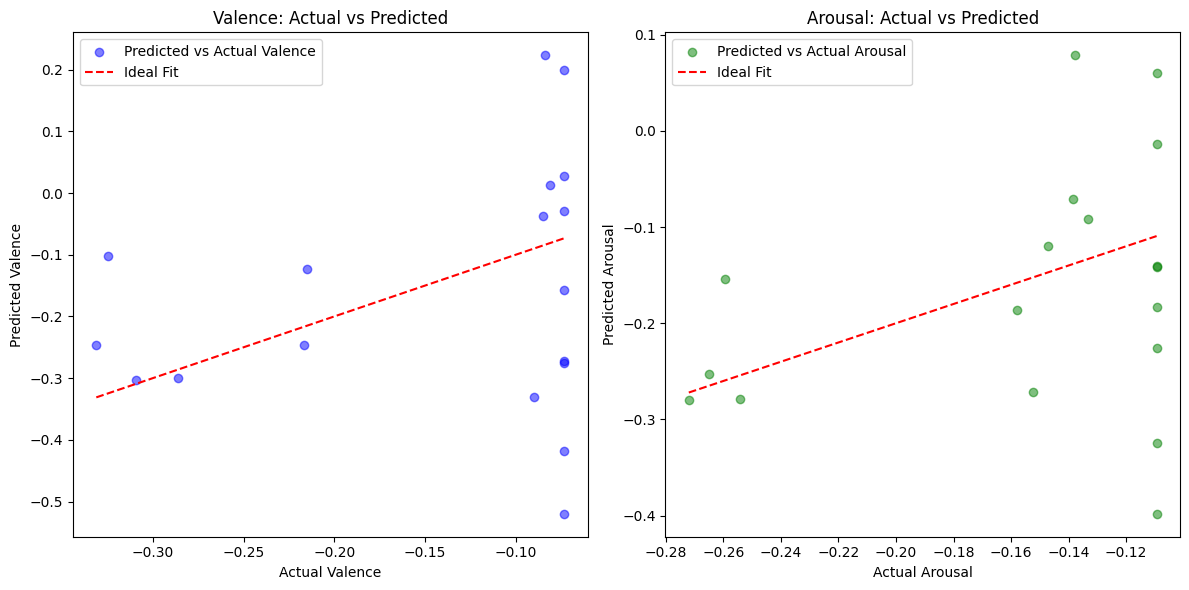

In [41]:
import matplotlib.pyplot as plt

# Plot Actual vs Predicted for Valence
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.scatter(y_test_valence_cleaned, y_pred_valence_cleaned, color='blue', alpha=0.5, label='Predicted vs Actual Valence')
plt.plot([y_test_valence_cleaned.min(), y_test_valence_cleaned.max()], [y_test_valence_cleaned.min(), y_test_valence_cleaned.max()], 'r--', label='Ideal Fit')
plt.xlabel('Actual Valence')
plt.ylabel('Predicted Valence')
plt.title('Valence: Actual vs Predicted')
plt.legend()

# Plot Actual vs Predicted for Arousal
plt.subplot(1, 2, 2)
plt.scatter(y_test_arousal_cleaned, y_pred_arousal_cleaned, color='green', alpha=0.5, label='Predicted vs Actual Arousal')
plt.plot([y_test_arousal_cleaned.min(), y_test_arousal_cleaned.max()], [y_test_arousal_cleaned.min(), y_test_arousal_cleaned.max()], 'r--', label='Ideal Fit')
plt.xlabel('Actual Arousal')
plt.ylabel('Predicted Arousal')
plt.title('Arousal: Actual vs Predicted')
plt.legend()

plt.tight_layout()
plt.show()


In [42]:
# Plot the distribution of happy/sad labels
import seaborn as sns

sns.countplot(x='label', data=features_cleaned)
plt.title('Distribution of Happy vs Sad Songs')
plt.xlabel('Label (0 = Sad, 1 = Happy)')
plt.ylabel('Count')
plt.show()


ValueError: Could not interpret value `label` for `x`. An entry with this name does not appear in `data`.